In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools

from skimage import util 
from skimage import data, color, io
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Machine Learning Engineer Nanodegree Capstone Project
## Problem Statement
The primary goal of this project is to predict digits from handwritten images. Recognizing digits is the most fundamental approach of handwriting recognition. This is a supervised classification problem where the model is expected to predict a number ranging from 0 to 9 by looking at an image with 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. The performance of the model can be computed by comparing the predicted number with the actual number.

## Requirements
* Anaconda
* sklearn 
* skimage

In [37]:
# Configs
MAX_PIXEL_VALUE = 255
RANDOM_STATE=37

# helper functions
def read_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df_target = df[["label"]]
    df_images = df.drop(["label"],axis=1).div(255)
    return df_target, df_images

def render_image(df_images, row_index, title):
    np_image = df_images.loc[row_index].to_numpy()
    # conver to arrays of image rows
    image = [np_image[x:x+28] for x in range(0, len(np_image),28)]

    # Plot
    f, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
# data pre-processing function
def resize_to_fit(df_images):
    np_images = df_images.to_numpy()
    np_images_resized = []
    for np_image in np_images:
        # conver to arrays of image rows
        image = [np_image[x:x+28] for x in range(0, len(np_image),28)]
        df_image = pd.DataFrame(image)
        # drop rows that are all zeros
        df_image = df_image[(df_image.T != 0).any()]
        # drop columns that are all zeros
        df_image = df_image.loc[:, (df_image != 0).any(axis=0)]
        
        # resize image
        np_image_resized = resize(df_image.to_numpy(), (28, 28) ,anti_aliasing=True)
        # add to final np array
        np_images_resized.append(np.concatenate(np_image_resized, axis=None))
    
    return pd.DataFrame(np_images_resized)

In [3]:
df_target, df_images = read_images("./data/train.csv")

## Data Exploration
The below shows example digit images of the original dataset.

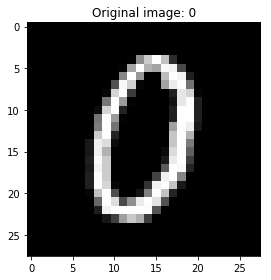

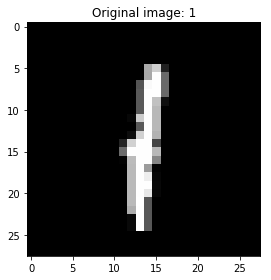

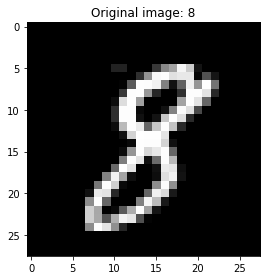

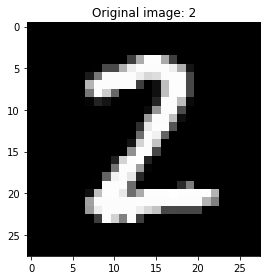

In [4]:
index = 5
render_image(df_images, index, "Original image: {}".format(df_target.loc[index].label))
index = 12
render_image(df_images, index, "Original image: {}".format(df_target.loc[index].label))
index = 20
render_image(df_images, index, "Original image: {}".format(df_target.loc[index].label))
index = 22
render_image(df_images, index, "Original image: {}".format(df_target.loc[index].label))

The images are pre-processed by eliminating the borders and resizing it back to 28x28. The below images are the examples of border eliminated digit images:

In [6]:
df_images_resized = resize_to_fit(df_images)

C:\Users\Taihwa\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


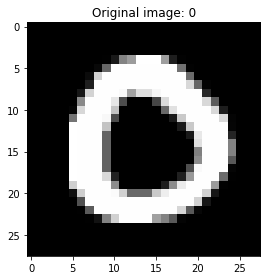

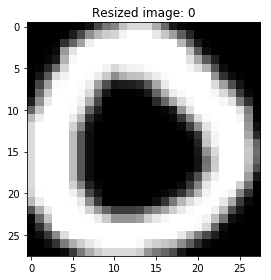

In [7]:
index = 4
render_image(df_images, index, "Original image: {}".format(df_target.loc[index].label))
render_image(df_images_resized, index, "Resized image: {}".format(df_target.loc[index].label))

The principal component analysis are done to reduce the dimensionality of the data set. Prior to applying PCA, test and train datasets are splitted. This is important because we do not want the test dataset to influence the result of PCA.

In [179]:
X_train, X_test, y_train, y_test = train_test_split(df_images_resized, df_target, test_size=0.2, random_state=RANDOM_STATE)

Once test and train dataset are splitted, we need to identify how many components to be used. The below image shows the total explained variance explained for each number of components. The result shows that by using 163 components, we can preserve 99% of the original data's variance.

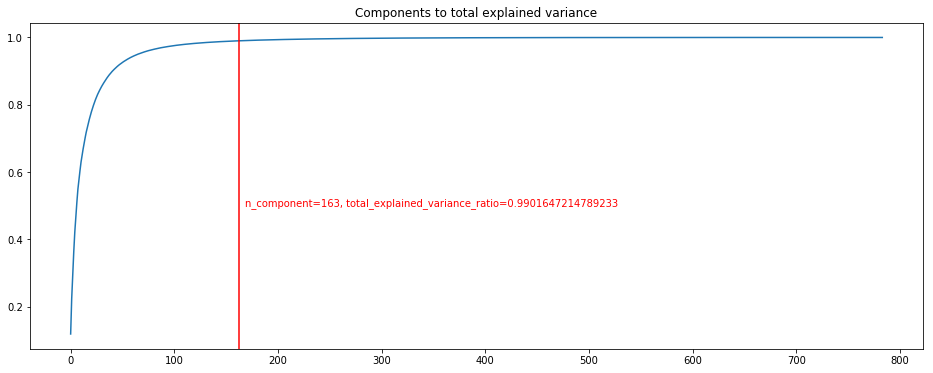

In [180]:
pca = PCA(n_components=784, svd_solver='full')
pca.fit(X_train)
total_explained_variance_ratio = 0
explained_variances = []
for explained in pca.explained_variance_ratio_:
    total_explained_variance_ratio += explained
    explained_variances.append(total_explained_variance_ratio)
n_component = [ n for n,i in enumerate(explained_variances) if i>0.99 ][0] + 1

f, ax = plt.subplots(figsize=(16,6))
ax.plot(explained_variances)
plt.title("Components to total explained variance")
plt.axvline(n_component-1, color='Red')
plt.text(n_component + 5, 
         0.5, 
         "n_component={}, total_explained_variance_ratio={}".format(n_component, explained_variances[n_component]),
         color="red")
plt.show()

Therefore, the cell below uses 163 components to compute the principal component analysis.

In [181]:
pca = PCA(n_components=n_component)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test  = pd.DataFrame(pca.transform(X_test))

## Model Training
For model training, three different learning algorithms will be used: logistic regression, K nearest neighbors and neural network.

### Logistic Regression
The accuracy score of the logistic regression model was 0.935. The benchmarking model showed 0.92 so our model outperformed the benchmarking model.

In [182]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9351190476190476

### KNN
The accuracy score of the K nearest neighbor was 0.970. The benchmarking model showed 0.970; therefore our model slightly performed better than the benchmarking model.

In [183]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4, n_jobs=4)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9703571428571428

### Neural Network
The accuracy score of the neural network was 0.98. The benchmarking model showed 0.98 so our model was performing just as good as the benchmarking model.

In [161]:
# Neural Netweork
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(1000,1000), random_state=RANDOM_STATE)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9803571428571428

## Refinements

### KNN hyper paramater tuning
The KNN classifier takes a hyper-parameter: n_neighbors. Upon making a decision, this number of closest data points are taken into consideration. The below graph demonstrates the relationship between the hyper parameter and the performance. As the number of neighbors increases, the accuracy decreases. Although the number of neighbors of 1 scored the highest, the model may not generalize. Once the number goes beyond 5, the accuracy decreases drastically. A number between 3 to 5 is a logical decision in this case. 

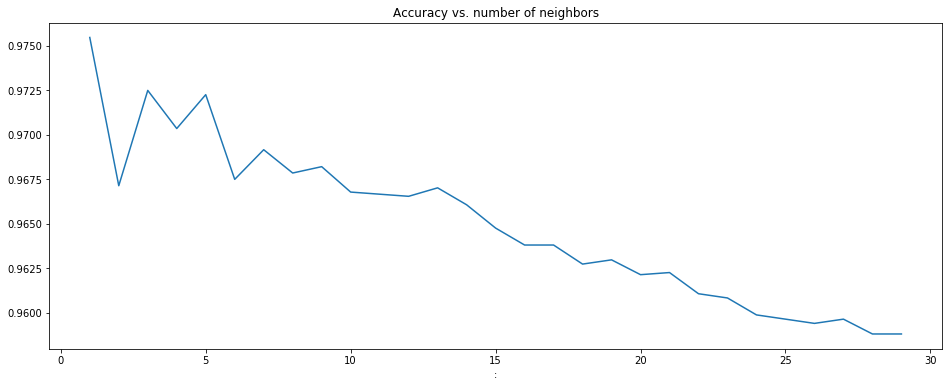

In [204]:
# KNN Hyper parameter tuning
accuracies, k = [], []
for n_neighbors in range(1, 30):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=4)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    k.append(n_neighbors)
f, ax = plt.subplots(figsize=(16,6))
ax.plot(k, accuracies)
plt.title("Accuracy vs. number of neighbors")
plt.xlabel(":")
plt.show()

### Neural Network hyper parameter tuning
Finding the number of nodes and the number of hidden layers is a tricky question for Neural Network models. The grid search algorithm is a handy technique  to fine-tune multiple hyper-parameters. Using the grid search algorithm, different numbers of nodes and the number of hidden layers were tested.


In [207]:
# NN Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
param_grid  = {
    'hidden_layer_sizes': [
        (100), (200), (500), (1000),          # single layer
        (100, 100), (500, 500), (1000, 1000), # two layers
    ],
}
clf = MLPClassifier(random_state=RANDOM_STATE)
search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=37, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [100, 200, 500, 1000, (100, 100), (500, 500), (1000, 1000)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

The result shows that 2 hidden layers each with 1000 nodes are proven to demonstrate the best result.

In [211]:
pd.concat([pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,hidden_layer_sizes,Accuracy
0,100,0.973333
1,200,0.976875
2,500,0.977946
3,1000,0.978839
4,"(100, 100)",0.971071
5,"(500, 500)",0.978274
6,"(1000, 1000)",0.980149


## Post hyperparameter tuned model outcomes
### Logistic Regression

In [293]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=1000)
clf_lr.fit(X_train, y_train.values.ravel())
y_pred = clf_lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.9351190476190476

The logistic regression failed images that are obvious to humans. The below images are the ones that the logistic regression model failed against. All of them are pretty obvious when a human is asked to interpret, but it failed on the model. This result can be inferred by the model performance: 93.51%. Logistic regression is a naive learner that is often not good at learning hidden behaviours; therefore, it often fails on some obvious images.

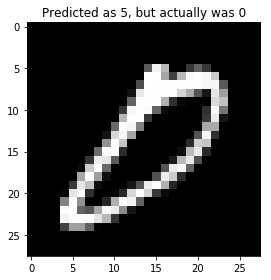

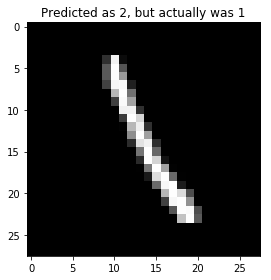

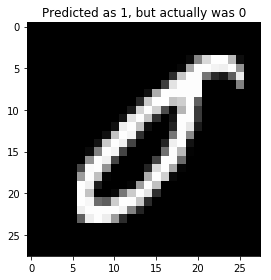

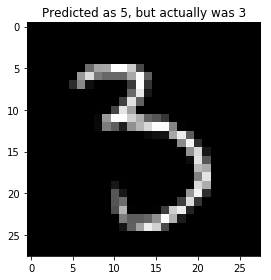

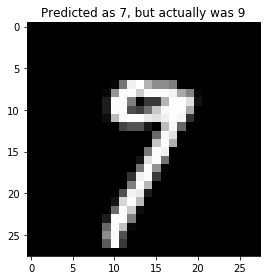

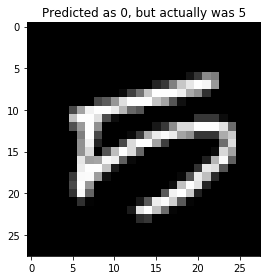

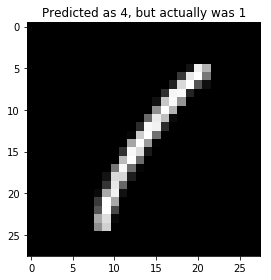

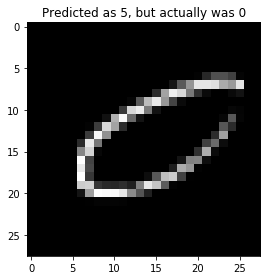

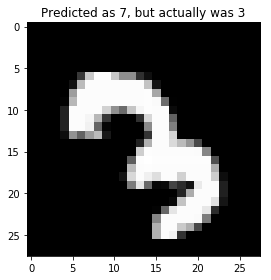

In [242]:
i = 0
mismatch_count = 0
max_render = 9
for index, row in y_test.iterrows():
    actual = row.label
    predicted = y_pred[i]
    if actual != predicted:
        render_image(df_images, index, "Predicted as {}, but actually was {}".format(predicted, actual))
        mismatch_count += 1
        if mismatch_count >= max_render:
            break
    i += 1

### KNN

In [292]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3, n_jobs=4)
clf_knn.fit(X_train, y_train.values.ravel())
y_pred = clf_knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9725

The KNN model failed against images that are often not obvious, but an average human may be able to classify it correctly. The below images are the ones that the KNN model failed against. Depending on how you look at the images, it can either be correctly identified or mis-classified upon eye-balling it. This explains why KNN shows a pretty robust performance: 97.25%

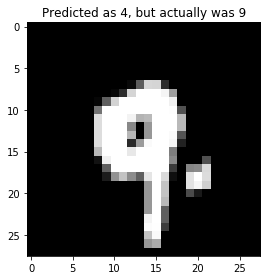

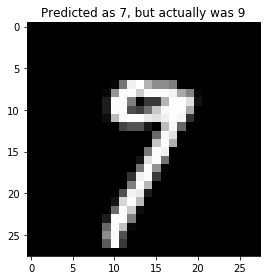

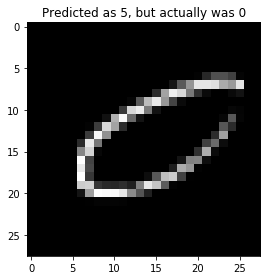

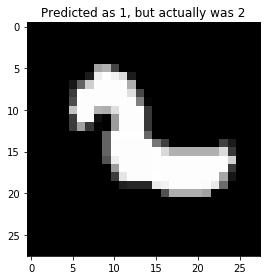

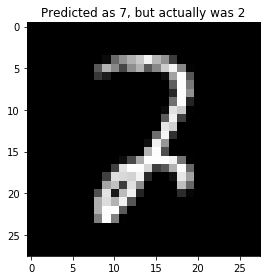

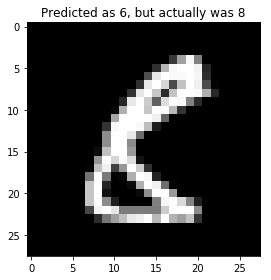

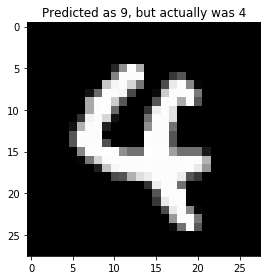

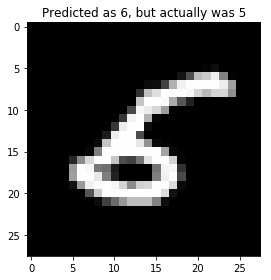

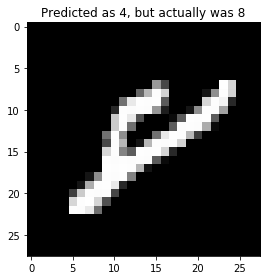

In [240]:
i = 0
mismatch_count = 0
max_render = 9
for index, row in y_test.iterrows():
    actual = row.label
    predicted = y_pred[i]
    if actual != predicted:
        render_image(df_images, index, "Predicted as {}, but actually was {}".format(predicted, actual))
        mismatch_count += 1
        if mismatch_count >= max_render:
            break
    i += 1

### Neural Network

In [291]:
# Neural Netweork
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(hidden_layer_sizes=(1000,1000), random_state=RANDOM_STATE)
clf_nn.fit(X_train, y_train.values.ravel())
y_pred = clf_nn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9811904761904762

The Neural Network model out-performed the other two with the accuracy score of 98.12%. Images that it mis-classified makes even an average person wonder about the actual outcome. The below has the images that the neural network model failed against.

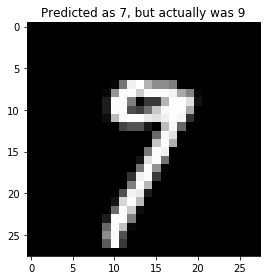

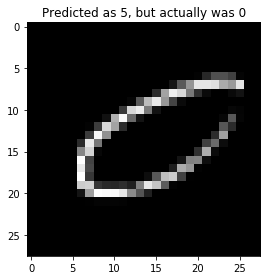

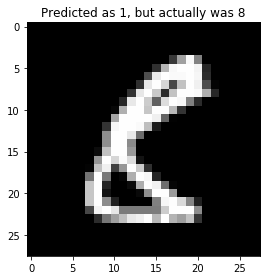

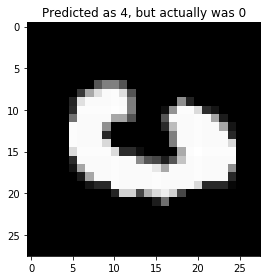

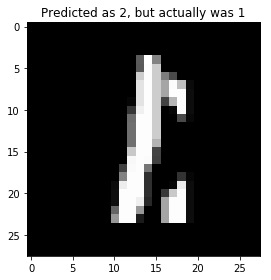

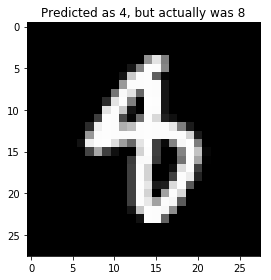

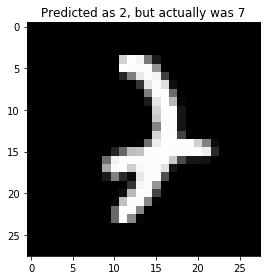

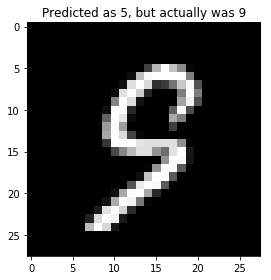

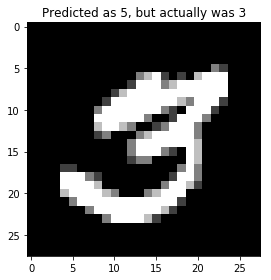

In [237]:
i = 0
mismatch_count = 0
max_render = 9
for index, row in y_test.iterrows():
    actual = row.label
    predicted = y_pred[i]
    if actual != predicted:
        render_image(df_images, index, "Predicted as {}, but actually was {}".format(predicted, actual))
        mismatch_count += 1
        if mismatch_count >= max_render:
            break
    i += 1

## Justification
In order to justify the robustness of the models, the models were tested against non-MNIST dataset. These hand-written digits were manually created and the total of 20 images were created. Some examples of the manually written digits are shown below.

In [351]:
rows = []
for filename in os.listdir(os.path.join("./data", "free_form")):
    file_path = os.path.join("./data", "free_form", filename)
    img = io.imread(file_path)
    img = rgb2gray(img)
    img = list(itertools.chain.from_iterable(img))
    label = int(filename[-5])
    row = [label]
    row.extend(img)
    rows.append(row)
df_freeform = pd.DataFrame(rows)
df_freeform_target = df_freeform[[0]]
df_freeform_images = df_freeform.drop([0],axis=1).div(255)
df_freeform_resized = resize_to_fit(df_freeform_images)
df_freeform_X = pca.transform(df_freeform_resized)

C:\Users\Taihwa\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


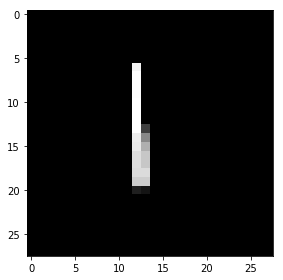

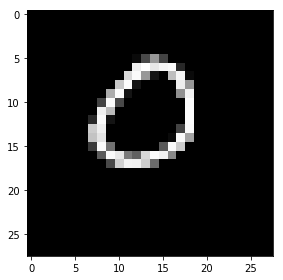

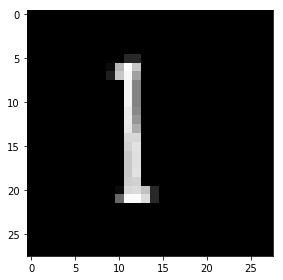

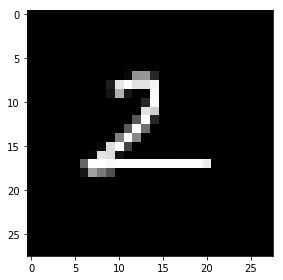

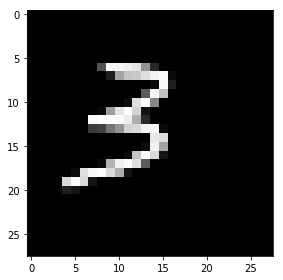

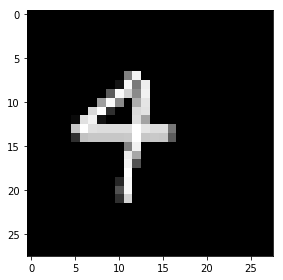

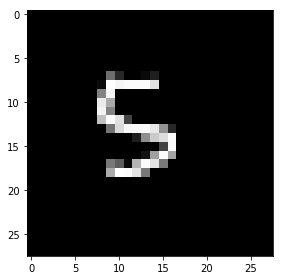

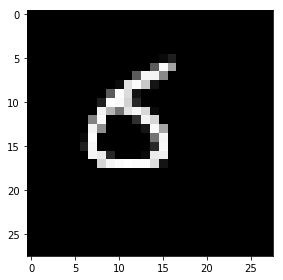

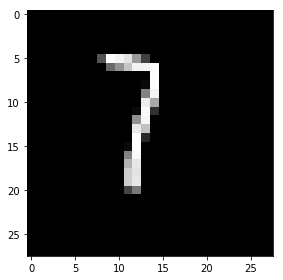

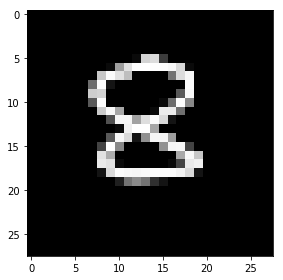

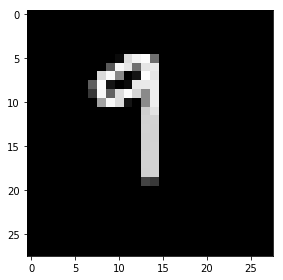

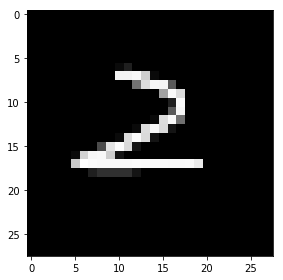

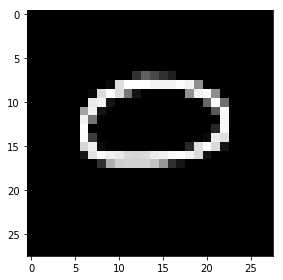

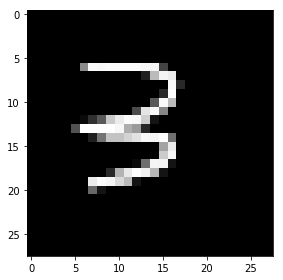

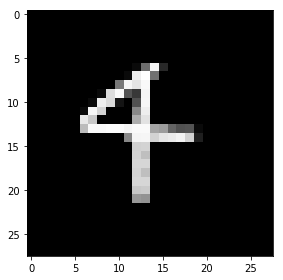

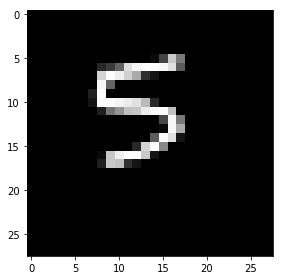

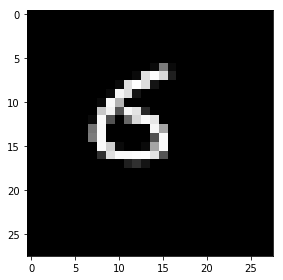

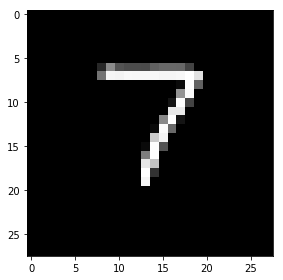

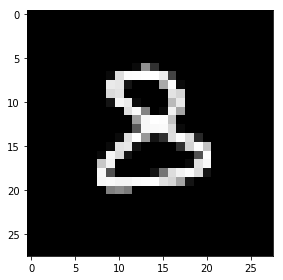

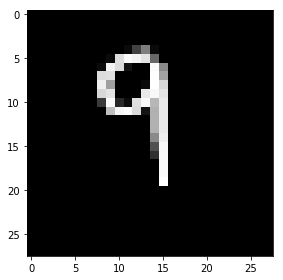

In [360]:
for index, row in df_freeform_images.iterrows():
    render_image(df_freeform_images, index, "")

The accuracy scores of all models are 1.0 (100%). This result justifies that the models work beyond the MNIST dataset and therefore can be generalized to any handwritten digits. 


In [358]:
# Predict
y_lr_pred = clf_lr.predict(df_freeform_X)
y_knn_pred = clf_knn.predict(df_freeform_X)
y_nn_pred = clf_nn.predict(df_freeform_X)

acc_lr = accuracy_score(df_freeform_target, y_lr_pred)
acc_knn = accuracy_score(df_freeform_target, y_knn_pred)
acc_nn = accuracy_score(df_freeform_target, y_nn_pred)
print("Accuracy score of logistic regression: {}".format(acc_lr))
print("Accuracy score of KNN: {}".format(acc_knn))
print("Accuracy score of neural network: {}".format(acc_nn))

Accuracy score of logistic regression: 1.0
Accuracy score of KNN: 1.0
Accuracy score of neural network: 1.0


## Conclusion
The accuracy score of the logistic regression model was 0.935. The benchmarking model showed 0.92 so our model outperformed the benchmarking model. The accuracy score of the K nearest neighbor was 0.973. The benchmarking model showed 0.970; therefore our model slightly performed better than the benchmarking model. The accuracy score of the neural network was 0.981. The benchmarking model showed 0.98 so our model was performing just as good as the benchmarking model.
